In [2]:
import pandas as pd

data = pd.read_csv("datasets/amazon_reviews.csv")

In [3]:
data.head()

,class_index,review_title,review_text
0,2,Great CD,My lovely Pat has one of the GREAT voices of h...
1,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [4]:
data['class_index'].value_counts()

class_index
2    200000
1    200000
Name: count, dtype: int64

In [5]:
data.isnull().sum()

class_index      0
review_title    24
review_text      0
dtype: int64

In [6]:
data.fillna('', inplace=True)
data.isnull().sum()

class_index     0
review_title    0
review_text     0
dtype: int64

In [7]:
data['class_index'] = data['class_index'] - 1
data.head()


,class_index,review_title,review_text
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...


In [8]:
data['review'] = data['review_title'] + ' ' + data['review_text']
data.head()

,class_index,review_title,review_text,review
0,1,Great CD,My lovely Pat has one of the GREAT voices of h...,Great CD My lovely Pat has one of the GREAT vo...
1,1,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...
3,1,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...,"works fine, but Maha Energy is better Check ou..."
4,1,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...,Great for the non-audiophile Reviewed quite a ...


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])  # Lemmatization
    return text

data['review'] = data['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seanlai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/seanlai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
from langdetect import detect

# Function to detect and remove non-English text
def is_english(text):
    try:
        return detect(text) == "en"
    except:
        return False
    
data = data[data['review'].apply(is_english)]

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [12]:
# Tokenization
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])

# Padding sequences
max_length = 100  # Define a max sequence length
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = np.array(data['class_index'])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential([
        Embedding(input_dim=5000, output_dim=hp.Choice('embedding_dim', [64, 128, 256]), input_length=max_length),
        LSTM(hp.Int('lstm_units', min_value=32, max_value=256, step=32), return_sequences=True),
        Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        LSTM(hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='bayesian_search',
    project_name='lstm_tuning'
)
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Trial 10 Complete [01h 29m 29s]
val_accuracy: 0.5020244121551514

Best val_accuracy So Far: 0.9060958623886108
Total elapsed time: 1d 09h 07m 16s


In [18]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best LSTM Units: {best_hps.get('lstm_units')}")
print(f"Best Dropout Rate: {best_hps.get('dropout')}")
print(f"Best LSTM 2 Units: {best_hps.get('lstm_units_2')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")


Best LSTM Units: 32
Best Dropout Rate: 0.4
Best LSTM 2 Units: 128
Best Learning Rate: 0.001


In [19]:
best_model = build_model(best_hps)
history = best_model.fit(
    X_train, y_train,
    epochs=5,
    validation_data=(X_test, y_test),
    verbose=1
)

/Users/seanlai/Projects/sentiment-analysis/.venv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
9911/9911 ━━━━━━━━━━━━━━━━━━━━ 611s 61ms/step - accuracy: 0.4974 - loss: 0.6939 - val_accuracy: 0.4980 - val_loss: 0.6945
Epoch 2/5
9911/9911 ━━━━━━━━━━━━━━━━━━━━ 602s 61ms/step - accuracy: 0.5178 - loss: 0.6767 - val_accuracy: 0.8830 - val_loss: 0.2845
Epoch 3/5
9911/9911 ━━━━━━━━━━━━━━━━━━━━ 590s 60ms/step - accuracy: 0.8908 - loss: 0.2695 - val_accuracy: 0.8980 - val_loss: 0.2475
Epoch 4/5
9911/9911 ━━━━━━━━━━━━━━━━━━━━ 627s 63ms/step - accuracy: 0.9075 - loss: 0.2293 - val_accuracy: 0.8994 - val_loss: 0.2443
Epoch 5/5
9911/9911 ━━━━━━━━━━━━━━━━━━━━ 2761s 279ms/step - accuracy: 0.9158 - loss: 0.2095 - val_accuracy: 0.9030 - val_loss: 0.2371


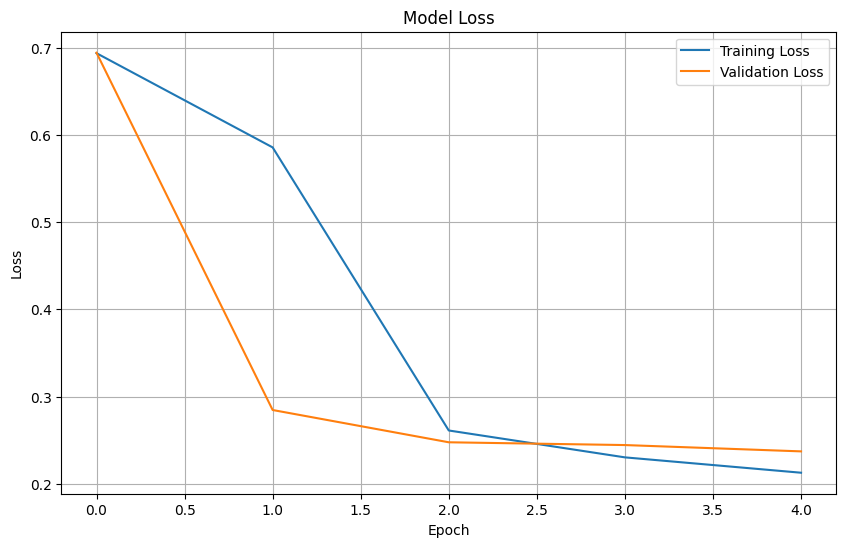

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

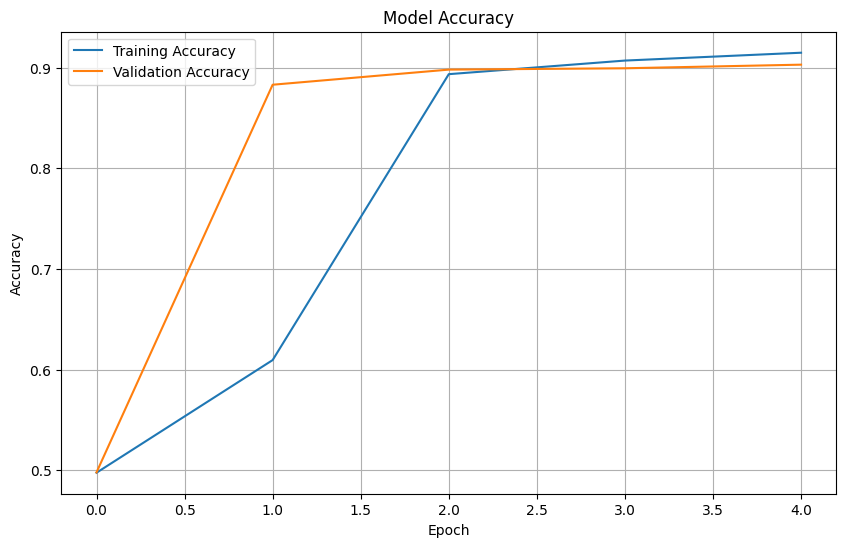

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import classification_report
import numpy as np

y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

2478/2478 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.90     39481
    Positive       0.91      0.90      0.90     39802

    accuracy                           0.90     79283
   macro avg       0.90      0.90      0.90     79283
weighted avg       0.90      0.90      0.90     79283



In [36]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 64)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,244,933 (4.75 MB)

 Trainable params: 414,977 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 829,956 (3.17 MB)

In [32]:
import pickle

best_model.save('sentiment_lstm_model.keras')

with open('lstm_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
from tensorflow.keras.models import load_model
import pickle

loaded_model = load_model('sentiment_lstm_model.keras')

with open('lstm_tokenizer.pickle', 'rb') as handle:
    loaded_tokenizer = pickle.load(handle)

def predict_sentiment(text, max_length=100):
    text = preprocess_text(text)

    sequence = loaded_tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post')

    prediction = loaded_model.predict(padded)[0][0]

    sentiment = "Positive" if prediction > 0.5 else "Negative"
    probability = prediction if prediction > 0.5 else 1 - prediction

    return {
        'sentiment': sentiment,
        'probability': float(probability),
        'raw_score': float(prediction)
    }

sample_text = 'This is so awesome!'
result = predict_sentiment(sample_text)
result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


{'sentiment': 'Positive',
 'probability': 0.9750813841819763,
 'raw_score': 0.9750813841819763}